<a href="https://colab.research.google.com/github/HaniMLK/RL-Projects/blob/LV-Flow-Navigation-Using-PPO/lv_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install stable-baselines3
!pip install imageio
!pip install matplotlib
!pip install scipy
!pip install imageio-ffmpeg
! pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.patches as patches
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import RegularGridInterpolator
import scipy.io as sio
import os

L = 1.0
A = 0.1
epsilon = 0.25
omega = 2 * np.pi / 10

def velocity_field(x, y, t):
    a = epsilon * np.sin(omega * t)
    b = 1 - 2 * a
    f = a * x**2 + b * x
    df_dx = 2 * a * x + b
    u = -np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * y)
    v = np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * y) * df_dx
    return u, v

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def load_vec_from_mat(mat_path):
    if not os.path.exists(mat_path):
        raise FileNotFoundError(f"MAT file not found: {mat_path}")
    data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    VEC_raw = data.get("VEC", None)
    if VEC_raw is None:
        raise KeyError("VEC variable not found in MAT file.")
    frames = []
    if isinstance(VEC_raw, np.ndarray):
        for k in range(VEC_raw.size):
            s = VEC_raw[k]
            frames.append({
                "X": np.array(s.X),
                "Y": np.array(s.Y),
                "U": np.array(s.U),
                "V": np.array(s.V),
                "C": np.array(s.C).astype(bool),
            })
    else:
        s = VEC_raw
        frames.append({
            "X": np.array(s.X),
            "Y": np.array(s.Y),
            "U": np.array(s.U),
            "V": np.array(s.V),
            "C": np.array(s.C).astype(bool),
        })
    t = data.get("t", None)
    if t is None:
        t = np.arange(len(frames), dtype=float)
    else:
        t = np.array(t).reshape(-1)
    return frames, t

def figure_to_rgb(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    return buf.reshape(h, w, 3)

def render_flow_preview(frames, t, out_gif, fps=15, sky=7, skx=5, sc=0.03, limit_frames=60):
    X0 = frames[0]["X"]; Y0 = frames[0]["Y"]
    xmin, xmax = float(X0.min()), float(X0.max())
    ymin, ymax = float(Y0.min()), float(Y0.max())
    Y_idx = np.arange(0, X0.shape[0], sky)
    X_idx = np.arange(0, X0.shape[1], skx)
    def sampled(frame):
        X = frame["X"][np.ix_(Y_idx, X_idx)]
        Y = frame["Y"][np.ix_(Y_idx, X_idx)]
        U = (sc * frame["U"])[np.ix_(Y_idx, X_idx)]
        V = (sc * frame["V"])[np.ix_(Y_idx, X_idx)]
        C = frame["C"][np.ix_(Y_idx, X_idx)]
        U = np.where(C, U, 0.0)
        V = np.where(C, V, 0.0)
        return X, Y, U, V
    N = min(limit_frames, len(frames))
    imgs = []
    fig, ax = plt.subplots(figsize=(6,4), dpi=100)
    Xq, Yq, Uq, Vq = sampled(frames[0])
    q = ax.quiver(Xq, Yq, Uq, Vq, angles='xy', scale_units='xy', scale=1.0)
    ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_aspect('equal', adjustable='box')
    title = ax.set_title(f"Healthy LV Flow  |  t = {t[0]:.3f} s")
    imgs.append(figure_to_rgb(fig))
    for i in range(1, N):
        Xq, Yq, Uq, Vq = sampled(frames[i])
        q.set_UVC(Uq, Vq)
        title.set_text(f"Healthy LV Flow  |  t = {t[i]:.3f} s")
        imgs.append(figure_to_rgb(fig))
    plt.close(fig)
    imageio.mimsave(out_gif, imgs, duration=1.0 / fps)

def render_flow_mp4(frames, t, out_mp4, fps=30, sky=7, skx=5, sc=0.03, time_subsample=1, bitrate=1800):
    frames = frames[::max(1, time_subsample)]
    t = t[::max(1, time_subsample)]
    X0 = frames[0]["X"]; Y0 = frames[0]["Y"]
    xmin, xmax = float(X0.min()), float(X0.max())
    ymin, ymax = float(Y0.min()), float(Y0.max())
    Y_idx = np.arange(0, X0.shape[0], sky)
    X_idx = np.arange(0, X0.shape[1], skx)
    def sampled(frame):
        X = frame["X"][np.ix_(Y_idx, X_idx)]
        Y = frame["Y"][np.ix_(Y_idx, X_idx)]
        U = (sc * frame["U"])[np.ix_(Y_idx, X_idx)]
        V = (sc * frame["V"])[np.ix_(Y_idx, X_idx)]
        C = frame["C"][np.ix_(Y_idx, X_idx)]
        U = np.where(C, U, 0.0)
        V = np.where(C, V, 0.0)
        return X, Y, U, V
    Xq, Yq, Uq, Vq = sampled(frames[0])
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=150)
    q = ax.quiver(Xq, Yq, Uq, Vq, angles='xy', scale_units='xy', scale=1.0)
    ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_aspect('equal', adjustable='box')
    title = ax.set_title(f"Healthy LV Flow  |  t = {t[0]:.3f} s")
    def init():
        q.set_UVC(Uq, Vq)
        title.set_text(f"Healthy LV Flow  |  t = {t[0]:.3f} s")
        return q, title
    def update(i):
        Xq, Yq, Uq, Vq = sampled(frames[i])
        q.set_UVC(Uq, Vq)
        title.set_text(f"Healthy LV Flow  |  t = {t[i]:.3f} s")
        return q, title
    anim = animation.FuncAnimation(fig, update, init_func=init, frames=len(frames), interval=1000/fps, blit=True)
    try:
        Writer = animation.FFMpegWriter
        writer = Writer(fps=fps, metadata=dict(artist='LVFlow'), bitrate=bitrate)
        anim.save(out_mp4, writer=writer)
        plt.close(fig); return
    except Exception:
        pass
    imgs = []
    for i in range(len(frames)):
        update(i)
        imgs.append(figure_to_rgb(fig))
    plt.close(fig)
    try:
        imageio.mimwrite(out_mp4, imgs, fps=fps, codec='libx264', quality=7)
    except Exception:
        imageio.mimwrite(out_mp4, imgs, fps=fps, codec='libx264', macro_block_size=1, quality=7)

In [ ]:
import gymnasium
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import scipy.io as sio
import matplotlib.patches as patches

class LVFlowRestrictedEnv(gym.Env):
    """
    LV Flow RL environment with hard boundary constraints:
    - Agent CANNOT leave LV region (mask C==True).
    - If action would leave region, agent stays put (no penalty).
    - Starts in top-right LV region, goal in top-left LV region.
    - Observation: [x, y, u, v].
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, mat_file="Healthy_flow_data.mat", max_steps=2000,
                 action_scale=0.05, step_dt=0.1, boundary_check_samples=20):
        super().__init__()

        self.frames, self.t_array = load_vec_from_mat(mat_file)
        self.num_frames = len(self.frames)

        # domain bounds
        X = self.frames[0]["X"]; Y = self.frames[0]["Y"]
        self.x_min, self.x_max = float(X.min()), float(X.max())
        self.y_min, self.y_max = float(Y.min()), float(Y.max())

        # simulation / environment settings
        self.max_steps = max_steps
        self.dt = step_dt
        self.frame_dt = 1
        self.action_scale = action_scale
        self.boundary_check_samples = int(boundary_check_samples)

        # reward shaping
        self.goal_radius = 0.03 * max(self.x_max - self.x_min, self.y_max - self.y_min)
        self.reach_reward = 200.0
        self.movement_penalty = -0.5
        self.time_penalty = -0.5

        # discrete actions: 8 directions + stay
        self.base_action_vectors = np.array([
            [0, 1.0], [1.0, 1.0], [1.0, 0], [1.0, -1.0],
            [0, -1.0], [-1.0, -1.0], [-1.0, 0], [-1.0, 1.0],
            [0.0, 0.0]
        ], dtype=np.float32)
        for i in range(len(self.base_action_vectors)-1):
            self.base_action_vectors[i] /= np.linalg.norm(self.base_action_vectors[i])
        self.action_space = spaces.Discrete(len(self.base_action_vectors))

        # observation = [x, y, u, v]
        self.observation_space = spaces.Box(
            low=np.array([self.x_min, self.y_min, -np.inf, -np.inf], dtype=np.float32),
            high=np.array([self.x_max, self.y_max, np.inf, np.inf], dtype=np.float32),
            dtype=np.float32
        )

        # interpolators
        self.interp_U, self.interp_V, self.interp_C = [], [], []
        for frame in self.frames:
            Y_axis, X_axis = frame["Y"][:, 0], frame["X"][0, :]
            self.interp_U.append(RegularGridInterpolator((Y_axis, X_axis), frame["U"],
                                                         bounds_error=False, fill_value=0.0))
            self.interp_V.append(RegularGridInterpolator((Y_axis, X_axis), frame["V"],
                                                         bounds_error=False, fill_value=0.0))
            self.interp_C.append(RegularGridInterpolator((Y_axis, X_axis), frame["C"].astype(float),
                                                         bounds_error=False, fill_value=0.0))

        self.reset()

    # --- helpers ---
    def _velocity_field(self, x, y, t_idx):
        t_idx = int(np.clip(t_idx, 0, self.num_frames - 1))
        u = float(self.interp_U[t_idx]((y, x)))
        v = float(self.interp_V[t_idx]((y, x)))
        return np.array([u, v], dtype=np.float32)

    def _point_inside(self, x, y, t_idx):
        val = float(self.interp_C[int(np.clip(t_idx, 0, self.num_frames - 1))]((y, x)))
        return val > 0.5

    def _segment_inside_mask(self, p1, p2, t_idx):
        samples = np.linspace(0.0, 1.0, self.boundary_check_samples)
        for s in samples:
            pt = p1 + s * (p2 - p1)
            if not self._point_inside(pt[0], pt[1], t_idx):
                return False
        return True

    # --- gym API ---
    def step(self, action):
        self.steps += 1
        prev_state = self.state.copy()
        flow_vec = self._velocity_field(self.state[0], self.state[1], self.t)
        act_vec = self.base_action_vectors[action] * self.action_scale
        proposed = self.state + (flow_vec + act_vec) * self.dt

        # keep inside bounds
        proposed[0] = np.clip(proposed[0], self.x_min, self.x_max)
        proposed[1] = np.clip(proposed[1], self.y_min, self.y_max)

        # check if the move would leave LV region
        if self._segment_inside_mask(prev_state, proposed, self.t):
            self.state = proposed.copy()  # accept move
        else:
            self.state = prev_state.copy()  # reject move (no penalty)

        # advance frame
        self.t = min(self.t + self.frame_dt, self.num_frames - 1)

        # compute reward
        dist_to_goal = np.linalg.norm(self.state - self.goal_center)
        reward = -10.0 * (dist_to_goal / np.linalg.norm(
            [self.x_max - self.x_min, self.y_max - self.y_min]))
        reward += self.time_penalty
        if action != (len(self.base_action_vectors)-1):
            reward += self.movement_penalty

        done = False
        truncated = False
        if dist_to_goal <= self.goal_radius:
            reward += self.reach_reward
            done = True

        if self.steps >= self.max_steps:
            truncated = True

        self.reward += reward
        self.trajectory.append(self.state.copy())

        flow_now = self._velocity_field(self.state[0], self.state[1], self.t)
        obs = np.array([self.state[0], self.state[1], flow_now[0], flow_now[1]], dtype=np.float32)
        info = {"t": self.t, "steps": self.steps}

        return obs, float(reward), done, truncated, info

    def reset(self, seed=None, options=None):
        rng = np.random.default_rng(seed)
        self.steps = 0
        self.reward = 0.0
        self.t = 0

        # define boxes for start (top-right) and goal (top-left)
        X = self.frames[0]["X"]; Y = self.frames[0]["Y"]
        x_mid = (self.x_min + self.x_max) / 2
        y_mid = (self.y_min + self.y_max) / 2
        start_box = [x_mid, self.x_max, y_mid, self.y_max]
        goal_box = [self.x_min, x_mid, y_mid, self.y_max]

        def sample_inside(box):
            for _ in range(500):
                x = rng.uniform(box[0], box[1])
                y = rng.uniform(box[2], box[3])
                if self._point_inside(x, y, 0):
                    return np.array([x, y], dtype=np.float32)
            return np.array([(box[0]+box[1])/2, (box[2]+box[3])/2], dtype=np.float32)

        self.state = sample_inside(start_box)
        self.goal_center = sample_inside(goal_box)
        self.trajectory = [self.state.copy()]

        flow_vec = self._velocity_field(self.state[0], self.state[1], self.t)
        obs = np.array([self.state[0], self.state[1], flow_vec[0], flow_vec[1]], dtype=np.float32)
        return obs, {}

    def render(self, mode='human'):
        plt.figure(figsize=(8, 8))
        frame_idx = min(int(self.t), self.num_frames - 1)
        frame = self.frames[frame_idx]
        X, Y, U, V = frame["X"], frame["Y"], frame["U"], frame["V"]
        plt.quiver(X, Y, U, V, color='lightgray', alpha=0.6)

        # mask boundary
        Cgrid = frame["C"].astype(float)
        plt.contour(X, Y, Cgrid, levels=[0.5], colors='navy', linewidths=1.5)

        traj = np.array(self.trajectory)
        plt.plot(traj[:, 0], traj[:, 1], '-o', color='red', markersize=3, label='Agent Path')
        plt.scatter(self.state[0], self.state[1], color='red', label='Agent')
        plt.scatter(self.goal_center[0], self.goal_center[1], color='cyan', s=80, label='Goal')
        plt.scatter(self.trajectory[0][0], self.trajectory[0][1], color='green', label='Start')
        circle_goal = patches.Circle(self.goal_center, self.goal_radius, color='cyan', alpha=0.2)
        plt.gca().add_patch(circle_goal)

        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.title(f"LV Flow Env (frame {frame_idx}) — Step {self.steps}")
        plt.gca().set_aspect('equal')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
env = LVFlowRestrictedEnv()
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0

    def _on_step(self) -> bool:
        done = self.locals["dones"][0]
        if done:
            info = self.locals["infos"][0]
            # Get episode reward from info dict
            ep_rew = info.get("episode", {}).get("r")
            ep_len = info.get("episode", {}).get("l")
            if ep_rew is not None:
                self.episode_rewards.append(ep_rew)
                self.episode_lengths.append(ep_len)
                self.episode_count += 1
        return True

model = DQN("MlpPolicy", env, verbose=1, buffer_size=1000000, batch_size=64)

callback = EpisodeRewardCallback()
model.learn(total_timesteps=1000000, callback=callback)
model.save("modelgyr")

# --- Plot average reward per episode ---
rewards = np.array(callback.episode_rewards)
episodes = np.arange(1, len(rewards) + 1)
avg_rewards = np.cumsum(rewards) / episodes

plt.figure(figsize=(10, 5))
plt.plot(episodes, avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward per Episode")
plt.title("Training Progress: Average Reward per Episode")
plt.grid(True)
plt.show()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 2e+03     |
|    ep_rew_mean      | -4.98e+03 |
|    exploration_rate | 0.924     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 295       |
|    time_elapsed     | 27        |
|    total_timesteps  | 8000      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 0.411     |
|    n_updates        | 1974      |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2e+03    |
|    ep_rew_mean      | -5.6e+03 |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 292      |
|    time_elapsed     | 54       |
|    total_timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 3974     |
----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 2e+03     |
|    ep_rew_mean      | -5.77e+03 |
|    exploration_rate | 0.772     |
| time/               |           |
|    episodes         | 12        |
|    fps              | 311       |
|    time_elapsed     | 77        |
|    total_timesteps  | 24000     |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 0.326     |
|    n_

In [ ]:
import h5py
import os

mat_file = "Healthy_flow_data.mat"

if os.path.exists(mat_file):
    try:
        with h5py.File(mat_file, 'r') as f:
            print(f"Successfully opened {mat_file} with h5py.")
            print("Keys in the file:", list(f.keys()))
            # You can try accessing a specific key to see if data can be read
            # For example, if you know there's a 'VEC' key:
            # if 'VEC' in f:
            #     print("Shape of 'VEC' dataset:", f['VEC'].shape)
            # else:
            #     print("'VEC' key not found in the file.")
    except Exception as e:
        print(f"Could not open {mat_file} with h5py. Error: {e}")
        print("This might indicate the file is corrupted or not in a format readable by h5py.")
        print("You may need to check the file with MATLAB or Octave.")
else:
    print(f"File not found: {mat_file}")

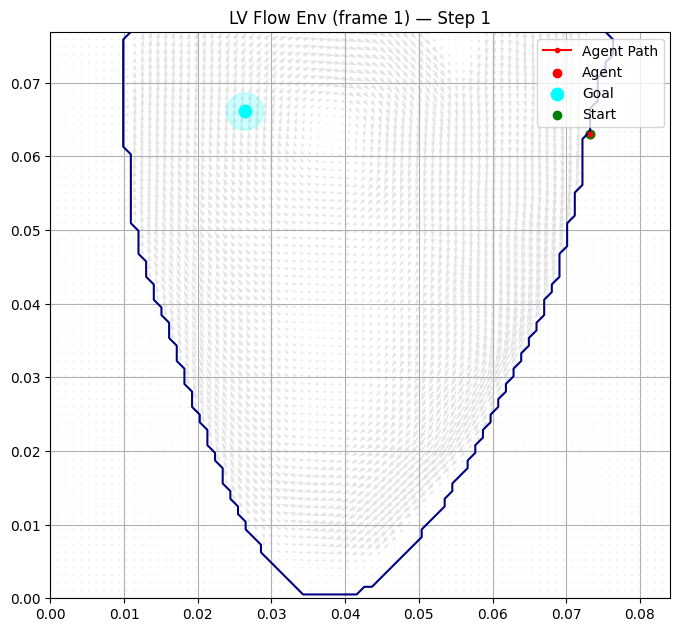

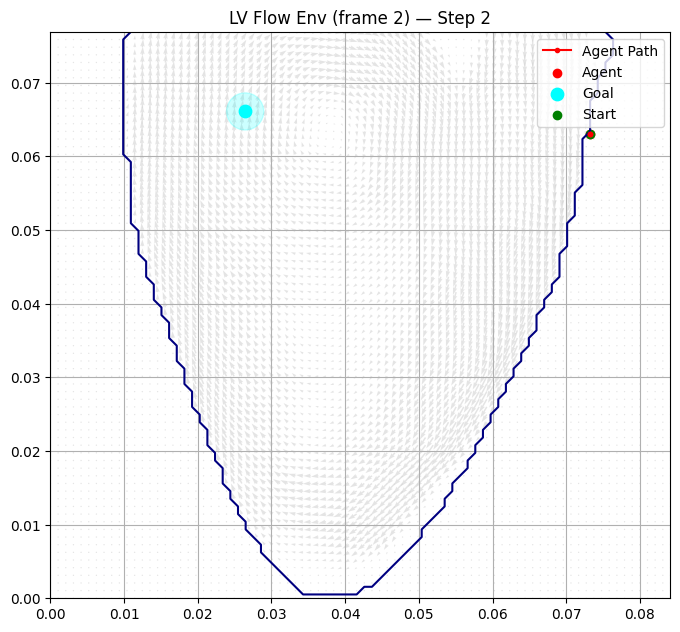

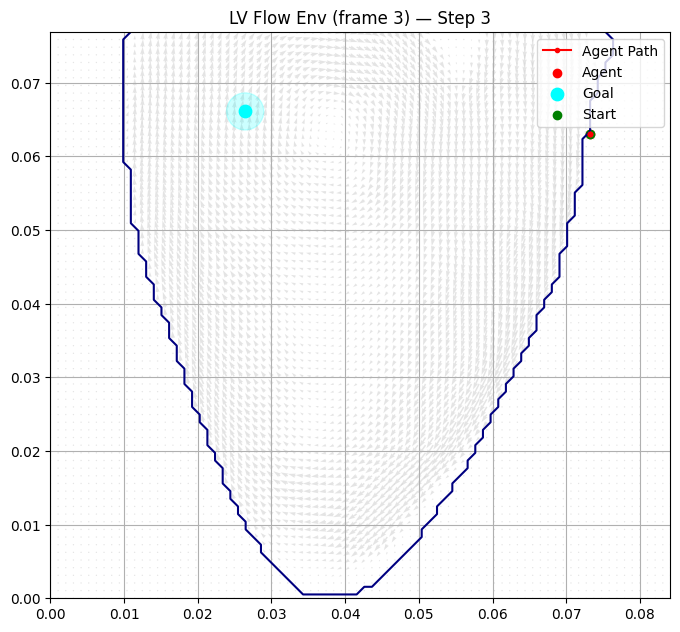

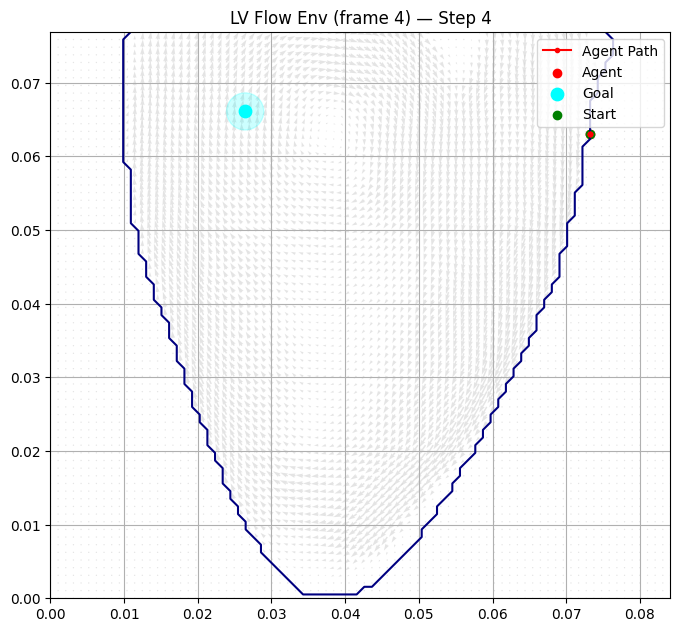

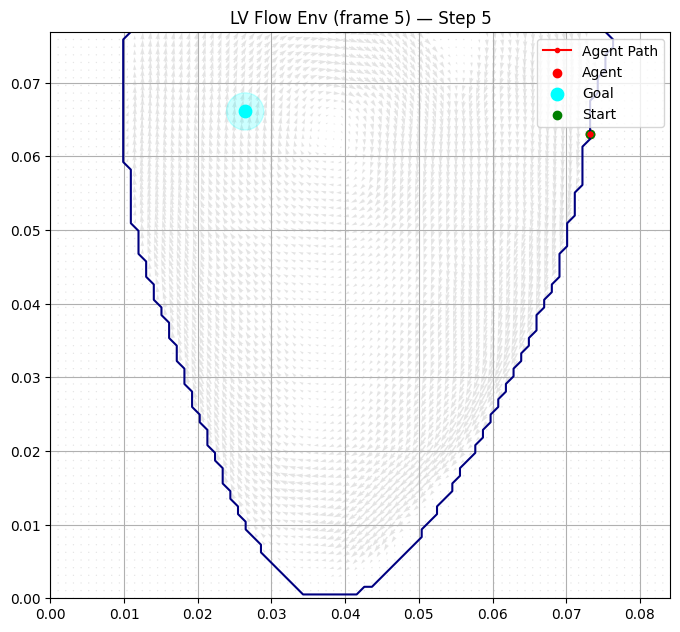

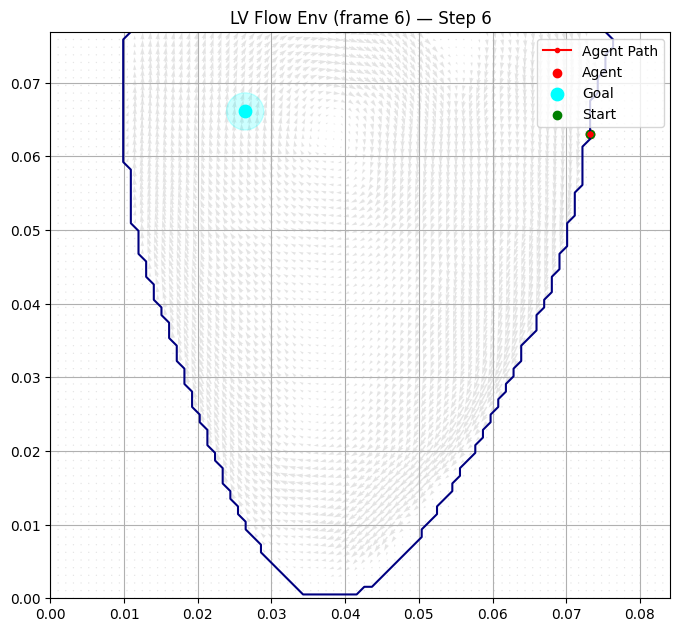

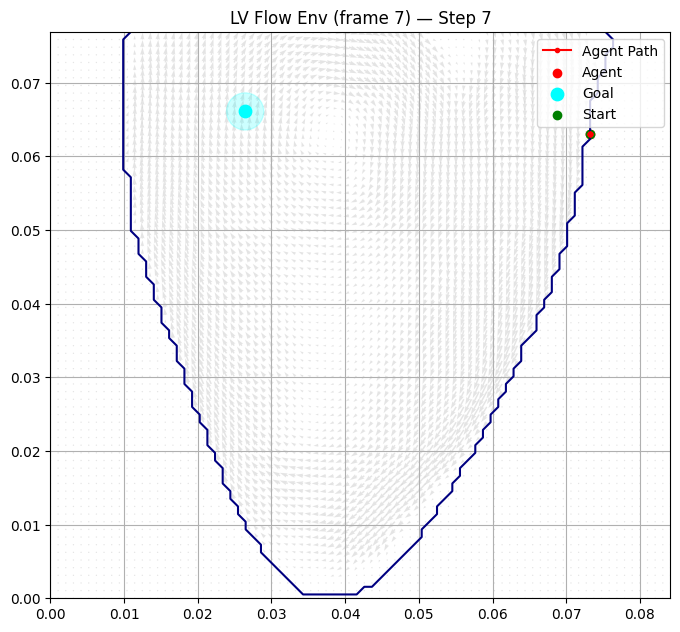

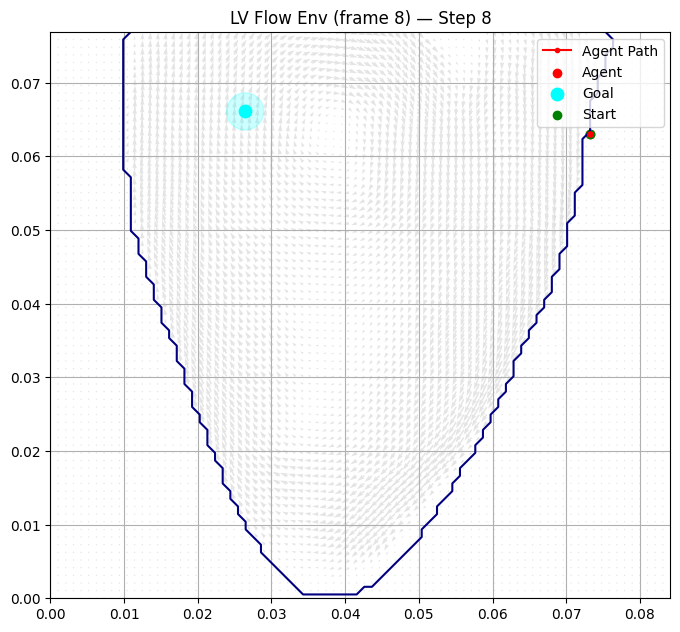

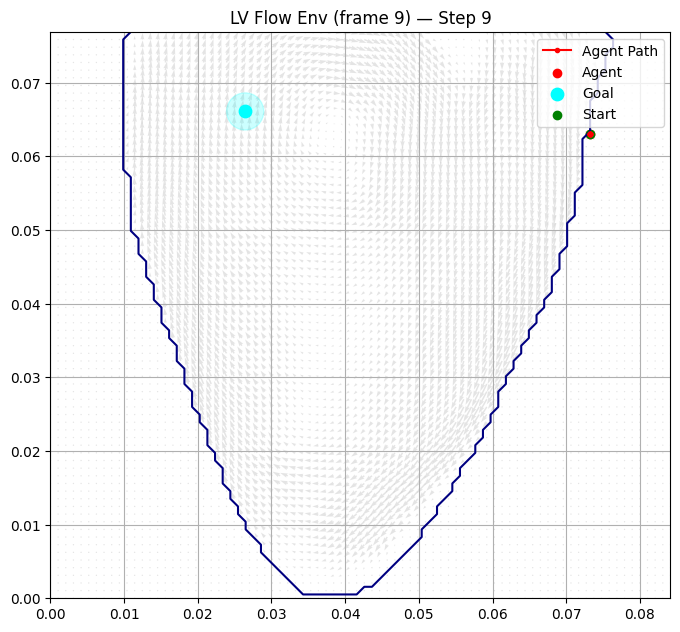

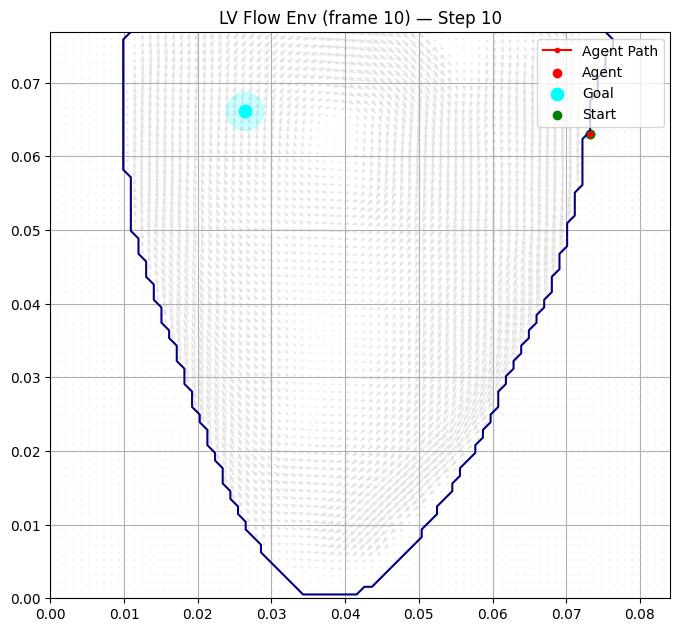

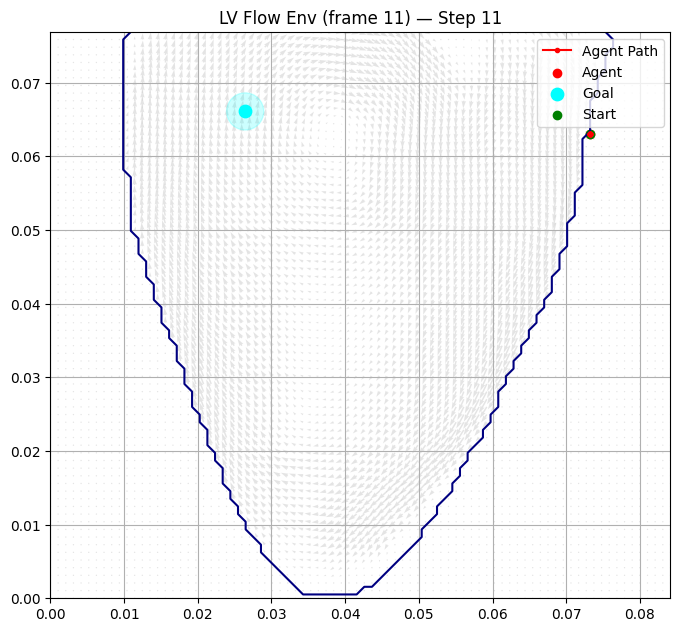

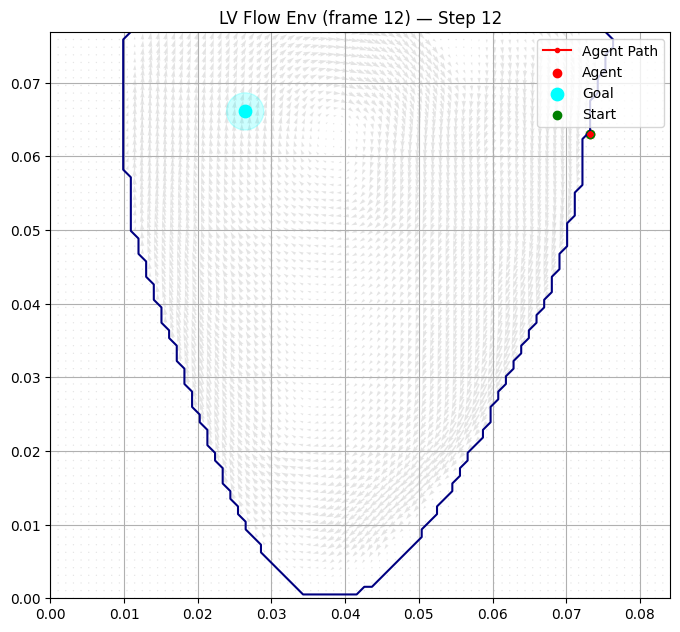

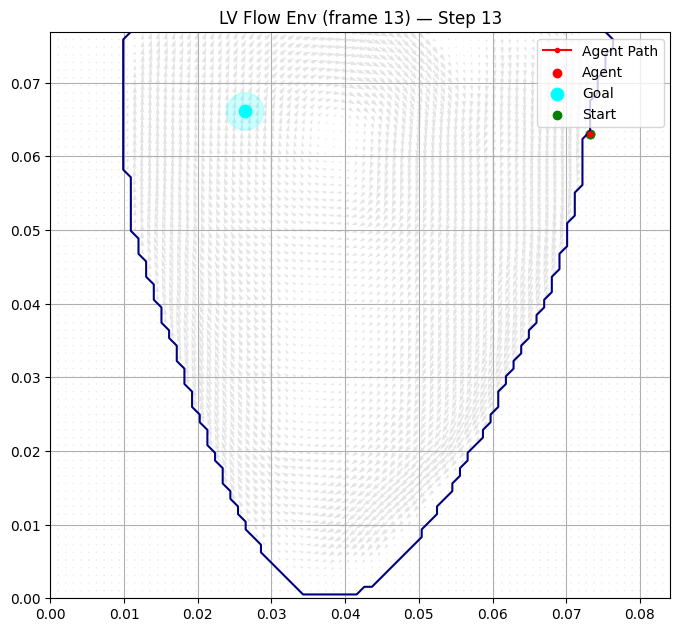

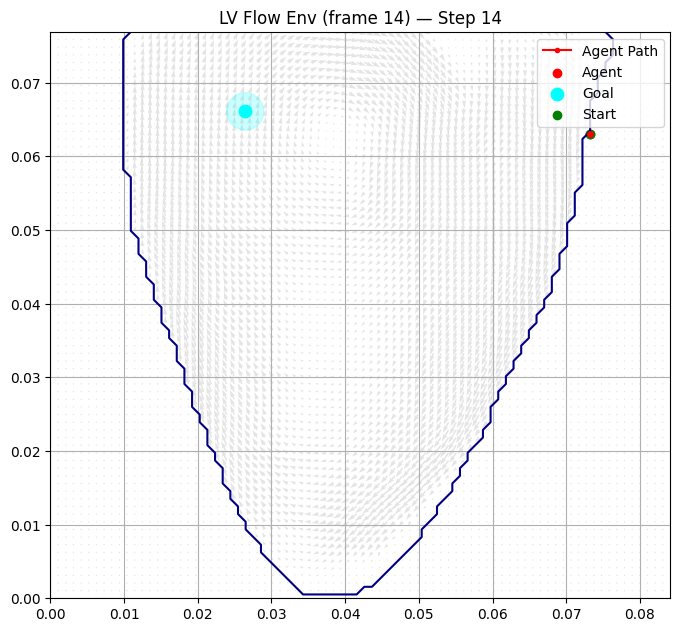

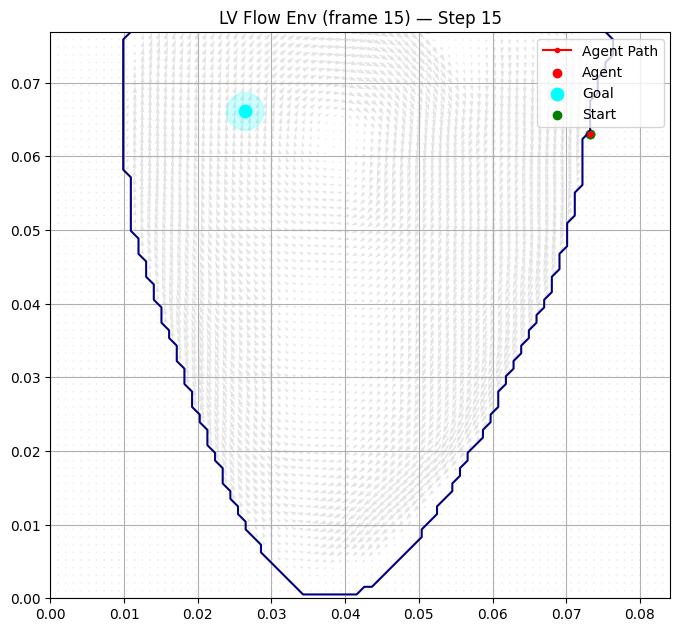

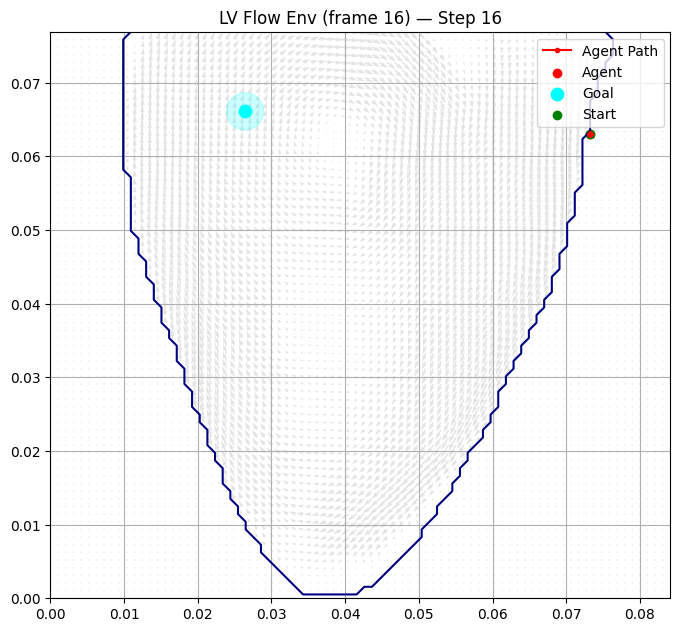

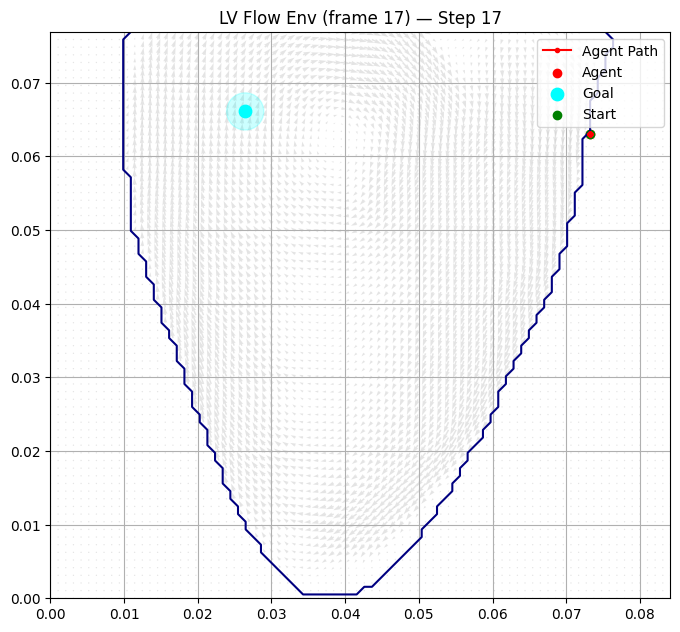

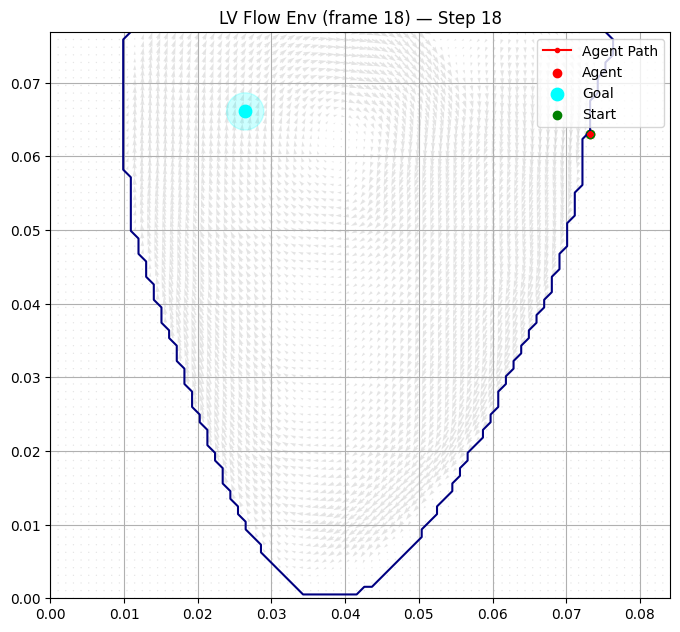

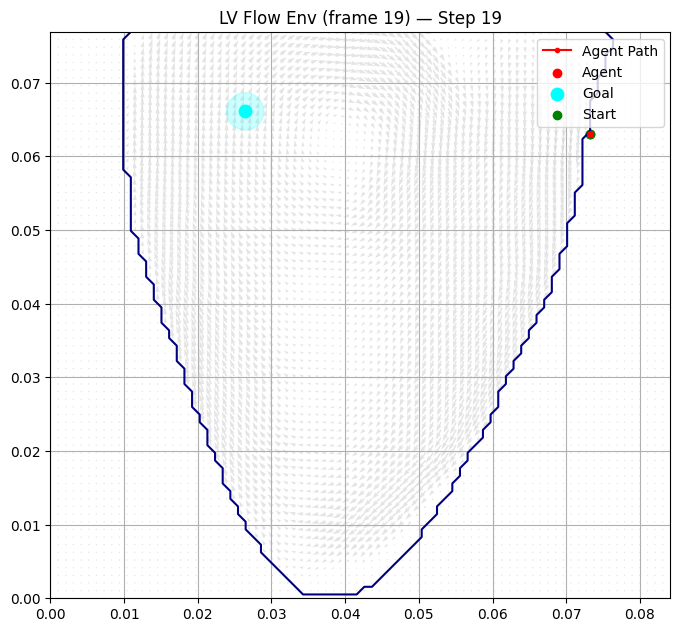

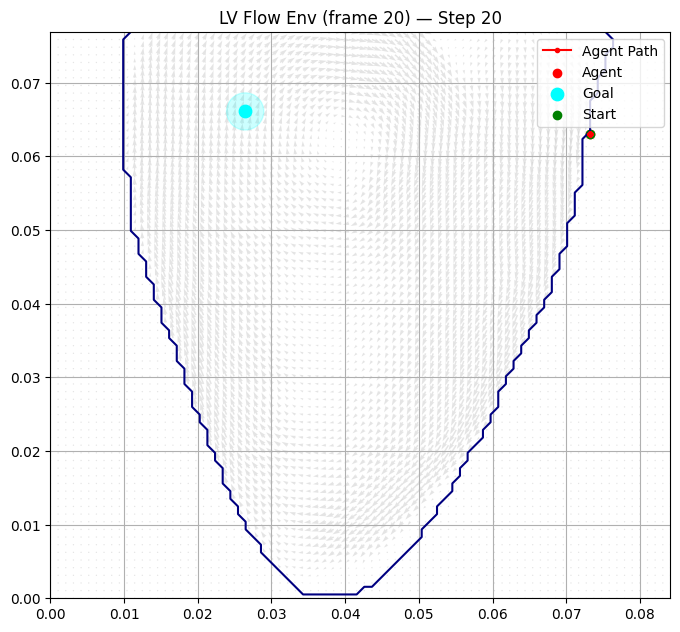

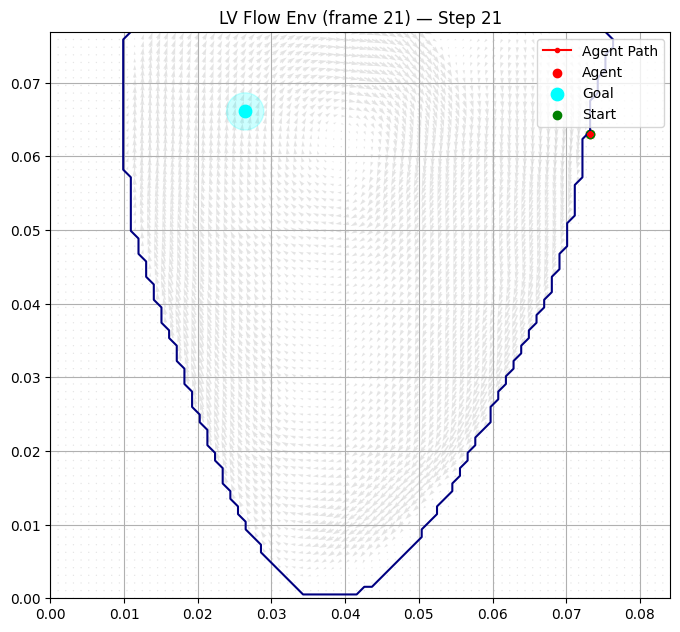

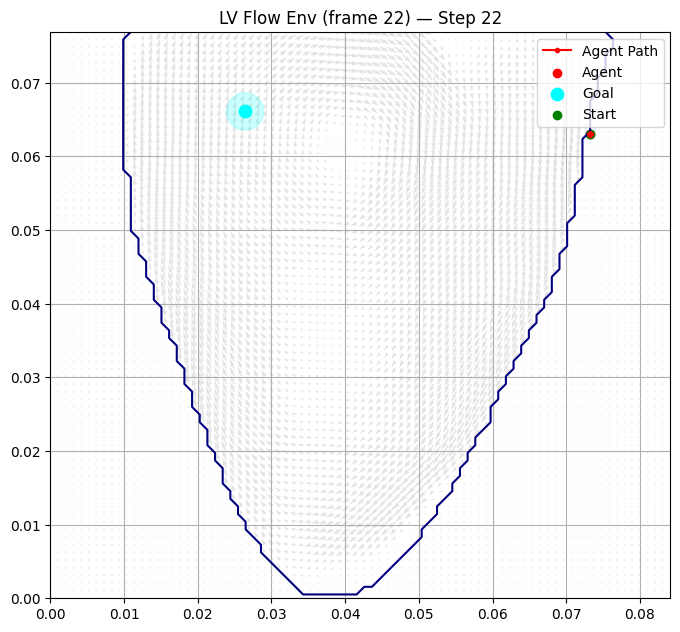

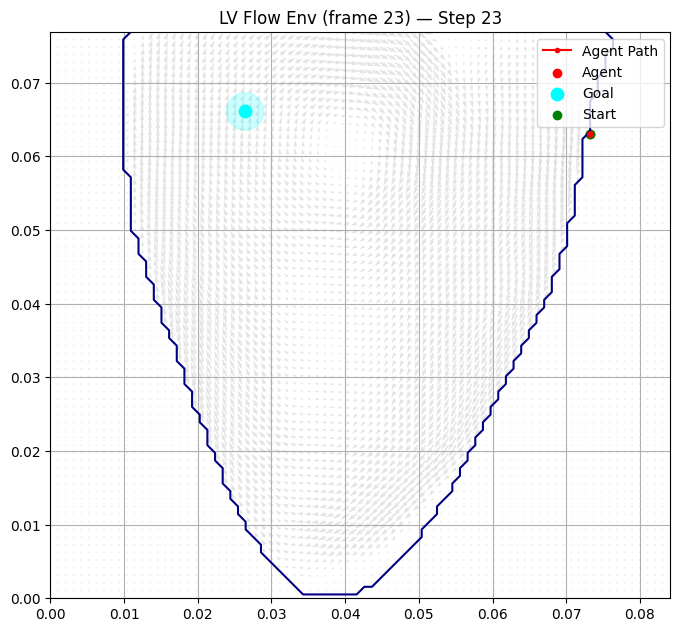

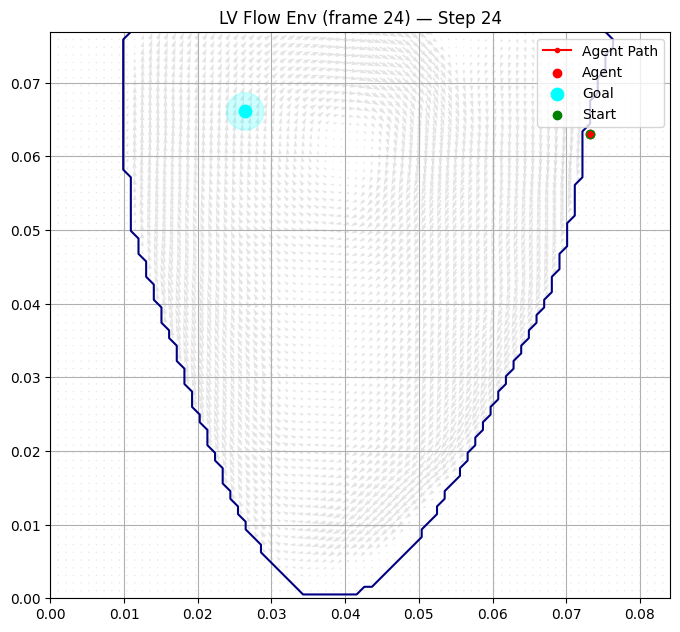

KeyboardInterrupt: 

In [ ]:
env = LVFlowRestrictedEnv()
# check_env(env)
obs, _ = env.reset()
done = False
env.history = [obs[:2]]
foo=0
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.history.append(obs[:2])
    # if(len(env.history)%20)==0:
    env.render()
    foo+=1

In [ ]:
from scipy.interpolate import make_interp_spline

def plot_trajectories(envs, mode='human'):
    import matplotlib.pyplot as plt
    from scipy.interpolate import make_interp_spline
    import matplotlib.patches as patches
    import numpy as np

    plt.figure(figsize=(10, 5))
    env = envs[0]
    x_min, x_max = env.x_min, env.x_max
    y_min, y_max = env.y_max, env.y_max # Fixed the y_min, y_max
    x_min, x_max = env.x_min, env.x_max # Added this line to fix x_min, x_max

    X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                       np.linspace(y_min, y_max, 25))
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    t_plot = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            u, v = env.velocity_field(X[i, j], Y[i, j], t_plot)
            U[i, j] = u
            V[i, j] = v

    norm = np.sqrt(U**2 + V**2)
    norm[norm == 0] = 1
    U_normalized = U / norm
    V_normalized = V / norm
    plt.quiver(X, Y, U_normalized, V_normalized, color='lightgray', alpha=0.7, label='Flow Field')

    success_count = 0
    total_traj = len(envs)

    # Determine successful and optimal environments
    successful_envs = []
    for env in envs:
        if env.successful_attemp:
            successful_envs.append(env)
            success_count+=1

    optimal_env = max(successful_envs, key=lambda e: e.reward) if successful_envs else None

    for env in envs:
        traj = np.array(env.trajectory)
        # Determine color and label
        if env is optimal_env:
            print(f"The best Trajectory was for env number:{env.run_id} it succeded in {env.t} steps and gainded reward of  {env.reward} and used {env.energy_used} energy!!")
            color = 'blue'
            label = 'Optimal Path'
            linewidth = 2
            alpha = 1.0
        else:
            color = 'green' if env.successful_attemp else 'red'
            label = 'Success Path' if env.successful_attemp else 'Failed Path'
            linewidth = 1
            alpha = 0.6

        # Smooth or straight plot
        if len(traj) > 3:
            t = np.linspace(0, 1, len(traj))
            t_fine = np.linspace(0, 1, 300)
            spl_x = make_interp_spline(t, traj[:, 0], k=3)
            spl_y = make_interp_spline(t, traj[:, 1], k=3)
            x_smooth = spl_x(t_fine)
            y_smooth = spl_y(t_fine)
            plt.plot(x_smooth, y_smooth, '-', color=color, label=label, linewidth=linewidth, alpha=alpha)
        else:
            plt.plot(traj[:, 0], traj[:, 1], '-o', color=color, label=label, markersize=3, linewidth=linewidth, alpha=alpha)

        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=8)
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=8)

    success_rate = (success_count / total_traj * 100) if total_traj > 0 else 0
    print(f"Success Rate: {success_rate:.2f}% ({success_count}/{total_traj} trajectories reached the goal)")

    goal = patches.Circle(env.goal_center, env.goal_radius, color='cyan', alpha=0.5, label='Goal')
    plt.gca().add_patch(goal)
    sample_circle = patches.Circle(env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Start Sampling Region')
    plt.gca().add_patch(sample_circle)
    target_sample_circle = patches.Circle(env.left_flow_center, env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', linewidth=1.5, fill=True, label='Target Sampling Region')
    plt.gca().add_patch(target_sample_circle)

    plt.gca().set_aspect('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Double Gyre with Smooth Agent Trajectories')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()

    if mode == 'human':
        plt.show()

    # === NEW PLOT: Optimal trajectory only ===
    if optimal_env is not None:
        traj = np.array(optimal_env.trajectory)

        plt.figure(figsize=(10, 5))
        X, Y = np.meshgrid(np.linspace(x_min, x_max, 50),
                           np.linspace(y_min, y_max, 25))
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                u, v = optimal_env.velocity_field(X[i, j], Y[i, j], t_plot)
                U[i, j] = u
                V[i, j] = v
        norm = np.sqrt(U**2 + V**2)
        norm[norm == 0] = 1
        plt.quiver(X, Y, U / norm, V / norm, color='lightgray', alpha=0.7, label='Flow Field')

        t = np.linspace(0, 1, len(traj))
        t_fine = np.linspace(0, 1, 300)
        spl_x = make_interp_spline(t, traj[:, 0], k=3)
        spl_y = make_interp_spline(t, traj[:, 1], k=3)
        x_smooth = spl_x(t_fine)
        y_smooth = spl_y(t_fine)

        plt.plot(x_smooth, y_smooth, '-', color='blue', linewidth=2.5, label='Optimal Path')
        plt.plot(traj[0, 0], traj[0, 1], 'go', markersize=10, label='Start')
        plt.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=10, label='Goal Reached')

        goal = patches.Circle(optimal_env.goal_center, optimal_env.goal_radius, color='cyan', alpha=0.5, label='Goal Region')
        plt.gca().add_patch(goal)
        sample_circle = patches.Circle(optimal_env.right_flow_center, 0.1, color='orange', alpha=0.2, linestyle='--', label='Start Sampling')
        plt.gca().add_patch(sample_circle)
        target_sample_circle = patches.Circle(optimal_env.left_flow_center, optimal_env.goal_sphere_radius, color='purple', alpha=0.2, linestyle='--', label='Target Sampling')
        plt.gca().add_patch(target_sample_circle)

        plt.gca().set_aspect('equal')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Optimal Trajectory (Shortest Successful Path)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if mode == 'human':
            plt.show()

envs=[]
for i in range(50):
    env = LVFlowRestrictedEnv()
    # check_env(env) # Commented out check_env as it can be time consuming
    obs, _ = env.reset()
    done = False
    env.history = [obs[:2]]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.history.append(obs[:2])
    # Adding run_id to env object if it's needed later for printing, not as an argument to reset
    env.run_id = i
    # Also adding successful_attemp, reward, and energy_used to env object for plotting
    env.successful_attemp = np.linalg.norm(env.state - env.goal_center) <= env.goal_radius
    env.reward = reward # Using the last step's reward; total reward is accumulated in env.reward
    env.energy_used = np.sum(np.linalg.norm(np.diff(np.array(env.trajectory), axis=0), axis=1)) # Simple metric for energy
    envs.append(env)
plot_trajectories(envs)

NameError: name 'model' is not defined

In [ ]:
envs=[]
for i in range(1000):
    env = LVFlowRestrictedEnv()
    check_env(env)
    obs, _ = env.reset()
    done = False
    env.history = [obs[:2]]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.history.append(obs[:2])
    envs.append(env)
plot_trajectories(envs)